In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, GridSearchCV
# StratifiedKFold : 불균형한 데이터 셋을 이용한 kfold 교차검증
# GridSearchCV : 머신러닝에서 모델의 성능향상을 위해 쓰이는 기법
from sklearn.feature_extraction.text import TfidfVectorizer # 자연어 처리
from sklearn.svm import SVC # 분류, 회귀, 특이점 판별에 쓰이는 지도 학습 머신 러닝 방법 중 하나
from sklearn.linear_model import LogisticRegression # 로지스틱 회귀 모형
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
# RandomForestClassifier : 랜덤 포레스트
# GradientBoostingClassifier : 
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, f1_score
# classification_report : scikitlearn에서 제공하는 매트릭스
# f1_score : 정밀도와 재현율의 조화평균

In [2]:
import re
import nltk # 자연어 처리를 위한 파이썬 패키지
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords # 분석에 큰 의미가 없는 단어 제거를 위함
from nltk.tokenize import RegexpTokenizer, word_tokenize
# RegexpTokenizer : 정규표현식을 이용한 문자 분해
# word_tokenize : 문장을 단어 단위로 분해
from nltk.util import ngrams # 문자열에서 N개의 연속된 요소를 추출하는 방법
from wordcloud import WordCloud

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style() # 그림의 전반적인 모양을 스타일링

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\cho03\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\cho03\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 데이터 로딩

In [4]:
df = pd.read_csv('C:/Users/cho03/Downloads/code/ex.csv')
df.head()

,review,sentiment
0,I don't know where to start!!\nPlot holes all ...,positive
1,I went in with the highest expectations and ca...,positive
2,great performancesincredible visualsstory ends...,positive
3,One of the best superhero movies I have ever w...,positive
4,The 10/10 reviews baffle me. HOW on earth? Peo...,positive


Shape:  (5000, 2)
sentiment
positive    4500
negative     500
Name: count, dtype: int64


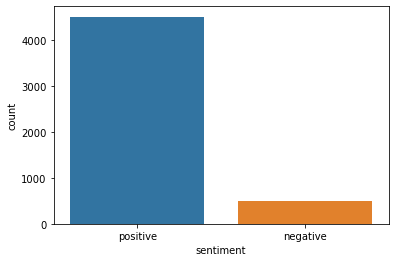

In [5]:
print('Shape: ', df.shape)
print(df['sentiment'].value_counts()) # 지정된 열의 각 값에 대한 발생 횟수 반환
sns.countplot(x=df['sentiment']); # 범주형 변수의 빈도수를 시각화

In [6]:
print('\nExample review:', df['review'][3]) # 리뷰 예시


Example review: One of the best superhero movies I have ever watched.All the actors really nailed their roles.Especially my one and only favorite iron man.Robert Downey Jr is irreplaceable in Iron man role.


## Feature Engineering

In [7]:
abbreviations = { #줄임말, 특수문자 교체
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

In [8]:
def convert_abbrev(word):
    return abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word

def convert_abbrev_in_text(text):
    tokens = word_tokenize(text) # text를 단어 단위로 나누기
    tokens = [convert_abbrev(word) for word in tokens]
    text = ' '.join(tokens)
    return text

In [9]:
# html 리메인 제거
df['review'] = df['review'].apply(lambda x: x.replace('<br />', '')) # 줄바꿈 변환
df['sentiment'].replace(['negative', 'positive'], [0, 1], inplace=True)

In [10]:
# 줄임말 변환
df['review'] = df['review'].apply(lambda x: convert_abbrev_in_text(x))

In [11]:
# 문장부호 & 토큰화 제거
tokenizer = RegexpTokenizer(r'\w+') # 단어 단위로 토큰을 나눔
df['tokens'] = df['review'].apply(tokenizer.tokenize)

In [12]:
# 분석에 큰 의미가 없는 단어 제거, 토큰 열 생성
stopwords = stopwords.words('english') # 분석에 큰 의미가 없는 단어 목록
df['tokens'] = df['tokens'].apply(lambda x: [w.lower() for w in x if w.lower() not in stopwords])

## 3. 탐색적 데이터 분석

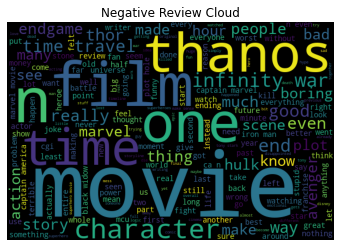

In [13]:
# 부정적 단어 Wordcloud
rvw_tokens = ''
for tokens in df[df['sentiment'] == 0]['tokens']:
    rvw_tokens += " ".join(tokens)
    
wordcloud = WordCloud(width=600, height=400).generate(rvw_tokens)

plt.figure(figsize = (6, 4))
plt.imshow(wordcloud)
plt.axis("off")
plt.title('Negative Review Cloud')
plt.show()

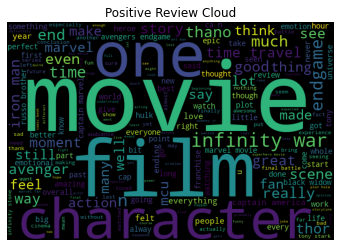

In [14]:
# 긍정적 단어 Wordcloud
rvw_tokens = ''
for tokens in df[df['sentiment'] == 1]['tokens']:
    rvw_tokens += " ".join(tokens)
    
wordcloud = WordCloud(width=600, height=400).generate(rvw_tokens)

plt.figure(figsize = (6, 4))
plt.imshow(wordcloud)
plt.axis("off")
plt.title('Positive Review Cloud')
plt.show()

## N-grams : 문자열에서 N개의 연속된 요소를 추출하는 방법

In [15]:
def extract_ngrams(tokens, num):
    n_grams = ngrams(tokens, num)
    n_grams = [ ' '.join(grams) for grams in n_grams]
    return n_grams

def count_ngrams(df, num):
    gram_dict = {}
    for i in df:
        grams = extract_ngrams(i, num)
        for j in grams:
            if j in gram_dict:
                gram_dict[j] += 1
            else:
                gram_dict[j] = 1
    gram_dict = dict(sorted(gram_dict.items(), key=lambda item: item[1], reverse=True))
    return gram_dict

## Unigrams : 1개의 단어로 토큰화

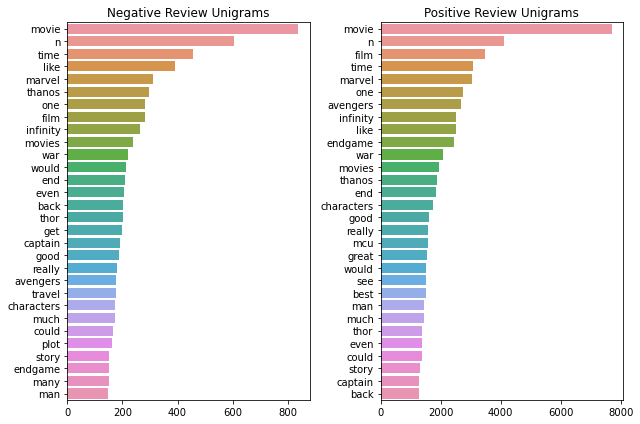

In [16]:
unigrams_neg = count_ngrams(df[df['sentiment']==0]['tokens'], 1)
unigrams_pos = count_ngrams(df[df['sentiment']==1]['tokens'], 1)

fig, axes = plt.subplots(1, 2, figsize=(9,6))
num = 30
sns.barplot(x=list(unigrams_neg.values())[:num], y=list(unigrams_neg.keys())[:num], ax=axes[0])
sns.barplot(x=list(unigrams_pos.values())[:num], y=list(unigrams_pos.keys())[:num], ax=axes[1])

axes[0].set_title('Negative Review Unigrams')
axes[1].set_title('Positive Review Unigrams')

plt.tight_layout()
plt.show()

## Bigrams : 2개의 단어로 토큰화

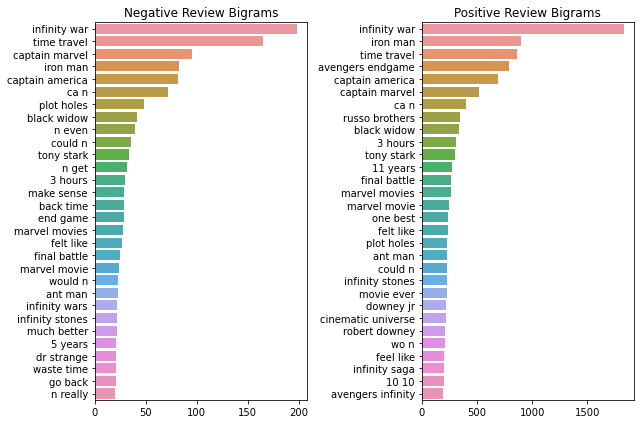

In [17]:
bigrams_neg = count_ngrams(df[df['sentiment']==0]['tokens'], 2)
bigrams_pos = count_ngrams(df[df['sentiment']==1]['tokens'], 2)

fig, axes = plt.subplots(1, 2, figsize=(9,6))
num = 30
sns.barplot(x=list(bigrams_neg.values())[:num], y=list(bigrams_neg.keys())[:num], ax=axes[0])
sns.barplot(x=list(bigrams_pos.values())[:num], y=list(bigrams_pos.keys())[:num], ax=axes[1])

axes[0].set_title('Negative Review Bigrams')
axes[1].set_title('Positive Review Bigrams')

plt.tight_layout()
plt.show()

## Trigrams : 3개의 단어로 토큰화

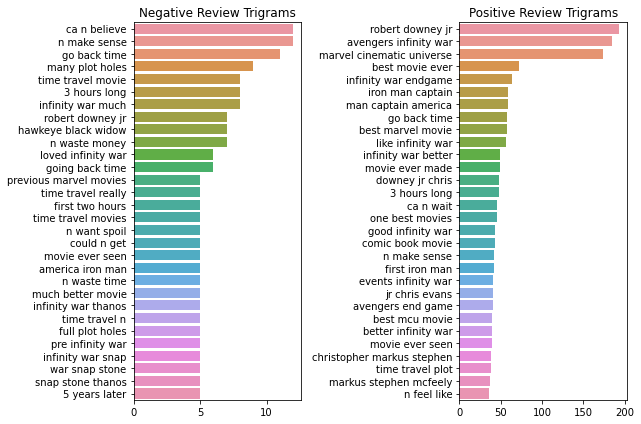

In [18]:
trigrams_neg = count_ngrams(df[df['sentiment']==0]['tokens'], 3)
trigrams_pos = count_ngrams(df[df['sentiment']==1]['tokens'], 3)

fig, axes = plt.subplots(1, 2, figsize=(9,6))
num = 30
sns.barplot(x=list(trigrams_neg.values())[:num], y=list(trigrams_neg.keys())[:num], ax=axes[0])
sns.barplot(x=list(trigrams_pos.values())[:num], y=list(trigrams_pos.keys())[:num], ax=axes[1])

axes[0].set_title('Negative Review Trigrams')
axes[1].set_title('Positive Review Trigrams')

plt.tight_layout()
plt.show()

## 4. Train-Test Split with Stratified K-Fold

In [19]:
X = df['review']
y = df['sentiment']

kfold = StratifiedKFold(n_splits=10)
for i, (train_idx, test_idx) in enumerate(kfold.split(X, y)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

## 5. Classification of Reviews


### 5.1 Logistic Regression

In [20]:
%%time
# 너무 많은 데이터를 원하지 않기 때문에 unigram과 bigram만 사용
# 또한 df_min=0.0001을 설정하여 빈도를 제한 -> 불필요한 희귀 단어를 제거
# => 모델 교육 속도 증가, 과대적합 최소화
pipeline_lr = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', ngram_range=(1,2), min_df=0.0001)),
    ("classifier", LogisticRegression()),
])

pipeline_lr.fit(X_train, y_train)
print(f'train score: {pipeline_lr.score(X_train, y_train)}')
print(f'test score: {pipeline_lr.score(X_test, y_test)}')

train score: 0.9004444444444445
test score: 0.902
CPU times: total: 3.47 s
Wall time: 6.1 s


In [21]:
y_pred = pipeline_lr.predict(X_test)
print('Classification Report:\n', classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))
print('F1 Score: ', f1_score(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

    Negative       1.00      0.02      0.04        50
    Positive       0.90      1.00      0.95       450

    accuracy                           0.90       500
   macro avg       0.95      0.51      0.49       500
weighted avg       0.91      0.90      0.86       500

F1 Score:  0.9483667017913593


### 5.2 Support Vector Classifier

In [23]:
%%time
pipeline_svc = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', ngram_range=(1,2), min_df=0.0001)),
    ("classifier", SVC()),
])

pipeline_svc.fit(X_train, y_train)
print(f'train score: {pipeline_svc.score(X_train, y_train)}')
print(f'test score: {pipeline_svc.score(X_test, y_test)}')

train score: 0.9866666666666667
test score: 0.9
CPU times: total: 56.2 s
Wall time: 1min 1s


In [24]:
y_pred = pipeline_svc.predict(X_test)
print('Classification Report:\n', classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))
print('F1 Score: ', f1_score(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

    Negative       0.00      0.00      0.00        50
    Positive       0.90      1.00      0.95       450

    accuracy                           0.90       500
   macro avg       0.45      0.50      0.47       500
weighted avg       0.81      0.90      0.85       500

F1 Score:  0.9473684210526316


C:\Users\cho03\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cho03\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cho03\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 5.3 Random Forest

In [25]:
%%time
pipeline_rf = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', ngram_range=(1,2), min_df=0.0001)),
    ("classifier", RandomForestClassifier()),
])

pipeline_rf.fit(X_train, y_train)
print(f'train score: {pipeline_rf.score(X_train, y_train)}')
print(f'test score: {pipeline_rf.score(X_test, y_test)}')

train score: 0.9997777777777778
test score: 0.904
CPU times: total: 18.4 s
Wall time: 20.4 s


In [26]:
y_pred = pipeline_rf.predict(X_test)
print('Classification Report:\n', classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))
print('F1 Score: ', f1_score(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

    Negative       1.00      0.04      0.08        50
    Positive       0.90      1.00      0.95       450

    accuracy                           0.90       500
   macro avg       0.95      0.52      0.51       500
weighted avg       0.91      0.90      0.86       500

F1 Score:  0.9493670886075949


### 5.4 Gradient Boosting Classifier


In [27]:
%%time
pipeline_gbc = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', ngram_range=(1,2), min_df=0.0001)),
    ("classifier", GradientBoostingClassifier()),
])

pipeline_gbc.fit(X_train, y_train)
print(f'train score: {pipeline_gbc.score(X_train, y_train)}')
print(f'test score: {pipeline_gbc.score(X_test, y_test)}')

train score: 0.9297777777777778
test score: 0.916
CPU times: total: 35.4 s
Wall time: 58 s


In [28]:
y_pred = pipeline_gbc.predict(X_test)
print('Classification Report:\n', classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))
print('F1 Score: ', f1_score(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

    Negative       0.75      0.24      0.36        50
    Positive       0.92      0.99      0.96       450

    accuracy                           0.92       500
   macro avg       0.84      0.62      0.66       500
weighted avg       0.90      0.92      0.90       500

F1 Score:  0.9550321199143469


## Hyper-parameter Tuning


In [29]:
%%time
pipeline_lr = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', ngram_range=(1,2), min_df=0.0001)),
    ("classifier", LogisticRegression()),
])

param = {'classifier__penalty' : ['l2'],
         'classifier__C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000],
         'classifier__max_iter': [10000]}  # we increase max_iter to avoid convergence error

gridsearch_lr = GridSearchCV(pipeline_lr, param, cv=5, verbose=3)
best_model = gridsearch_lr.fit(X_train,y_train)

print(f'train score: {best_model.score(X_train, y_train)}')
print(f'test score: {best_model.score(X_test, y_test)}')

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV 1/5] END classifier__C=0.001, classifier__max_iter=10000, classifier__penalty=l2;, score=0.900 total time=   3.6s
[CV 2/5] END classifier__C=0.001, classifier__max_iter=10000, classifier__penalty=l2;, score=0.900 total time=   3.2s
[CV 3/5] END classifier__C=0.001, classifier__max_iter=10000, classifier__penalty=l2;, score=0.900 total time=   3.2s
[CV 4/5] END classifier__C=0.001, classifier__max_iter=10000, classifier__penalty=l2;, score=0.900 total time=   3.3s
[CV 5/5] END classifier__C=0.001, classifier__max_iter=10000, classifier__penalty=l2;, score=0.900 total time=   3.4s
[CV 1/5] END classifier__C=0.01, classifier__max_iter=10000, classifier__penalty=l2;, score=0.900 total time=   3.2s
[CV 2/5] END classifier__C=0.01, classifier__max_iter=10000, classifier__penalty=l2;, score=0.900 total time=   3.3s
[CV 3/5] END classifier__C=0.01, classifier__max_iter=10000, classifier__penalty=l2;, score=0.900 total time=   3.4s

In [30]:
y_pred = best_model.predict(X_test)
print('Classification Report:\n', classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))
print('F1 Score: ', f1_score(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

    Negative       0.87      0.26      0.40        50
    Positive       0.92      1.00      0.96       450

    accuracy                           0.92       500
   macro avg       0.90      0.63      0.68       500
weighted avg       0.92      0.92      0.90       500

F1 Score:  0.9582887700534759
